# Result Analysis
1. SCAN

In [67]:
import os
from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [68]:
# I/O
RESULT = 'result'
LOG = 'log'
EXP1 = 'exp1'
EXP2 = 'exp2'
EXP3 = 'exp3'
EXP4 = 'exp4'

## Helper Function

In [69]:
def load_txt(path: str) -> list:
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().splitlines()

In [86]:
data_src = 'scan_l1'
model_name = 'bi_lstm_rnn_att'
task = 10 # number of primitives
exp = EXP1

# Log

In [87]:
raw_result = load_txt(os.path.join(LOG, exp, data_src, str(task), model_name, 'test.txt'))

In [88]:
epochs, tk_acc, seq_acc = [], [], []
for r in raw_result:
    if 'Test Epoch' in r:
        r = r.split()
        epochs.append(r[2])
        tk_acc.append(r[-3].split(':')[-1])
        seq_acc.append(r[-1].split(':')[-1])

epochs = [int(e) for e in epochs]
tk_acc = [float(a) for a in tk_acc]
seq_acc = [float(a) for a in seq_acc]

In [89]:
tk_acc

[0.7306, 0.7609, 0.8045, 0.8262, 0.8338, 0.8352, 0.8445, 0.8159, 0.8236, 0.832]

In [90]:
print(seq_acc)

[0.1451, 0.18, 0.3065, 0.3938, 0.4105, 0.4284, 0.457, 0.3845, 0.4233, 0.4266]


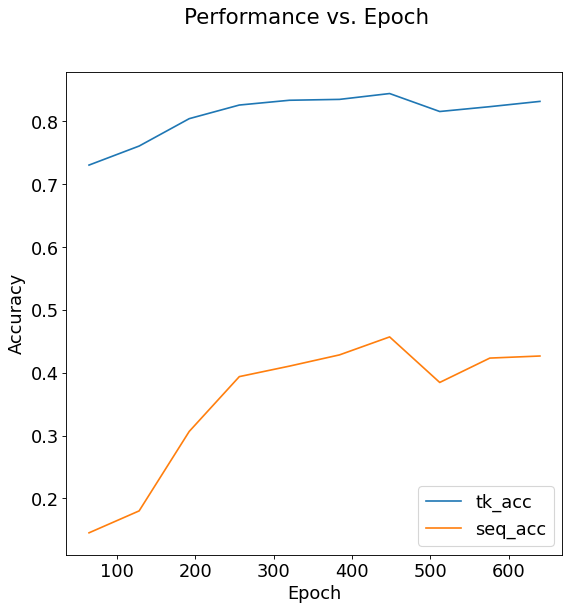

In [91]:
plt.subplots(figsize = (8, 8), dpi=80)
plt.plot(epochs, tk_acc, label='tk_acc')
plt.plot(epochs, seq_acc, label='seq_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('Performance vs. Epoch')
plt.legend()
plt.show()

# Result

In [92]:
raw_result = load_txt(os.path.join(RESULT, exp, data_src, str(task), model_name, 'test.txt'))

In [93]:
raw_result[:10]

['Src: run_0 left twice and run_0 right thrice',
 'Tgt: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN',
 'Pred: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN </s>',
 'Src: run_0 right after run_0 left thrice',
 'Tgt: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN',
 'Pred: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_RUN </s>',
 'Src: run_0 around right thrice and run_0 twice',
 'Tgt: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_RUN I_RUN',
 'Pred: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_RUN </

In [94]:
xs, ys, ys_ = [], [], []
for r in raw_result:
    if 'turn' not in r:
        if 'Src: ' in r:
            xs.append(r.split('Src: ')[-1])
        elif 'Tgt:' in r:
            ys.append(r.split('Tgt: ')[-1])
        elif 'Pred: ' in r:
            ys_.append(r.split('Pred: ')[-1])
        else:
            print(r)
    else:
        print(r)

In [95]:
# sequence accuracy
len([_ for y, y_ in zip(ys, ys_) if y == y_]) / len(xs)

0.4266075388026608

In [96]:
xs[0]

'run_0 left twice and run_0 right thrice'

## Primitives

In [97]:
extra_primitive_xs = ['run', 'jump', 'look', 'walk']
extra_primitive_ys = ['I_RUN', 'I_JUMP', 'I_LOOK', 'I_WALK']
new_primitives = [p + '_{}'.format(i) for i in range(task) for p in extra_primitive_xs]

### Sequence Accuracy

In [98]:
# source vocab
c = Counter()
for x in xs:
    c.update(x.split())

all_dict = {p:c[p] for p in new_primitives}

In [99]:
# true vocab
c = Counter()
for x, y, y_ in zip(xs, ys, ys_):
    if y == y_:
        c.update(x.split())
        
true_dict = {p:c[p] for p in new_primitives}

In [100]:
# seq acc per primitive
primitive_seq_acc_dict = {p: true_dict[p]/all_dict[p] for p in new_primitives}

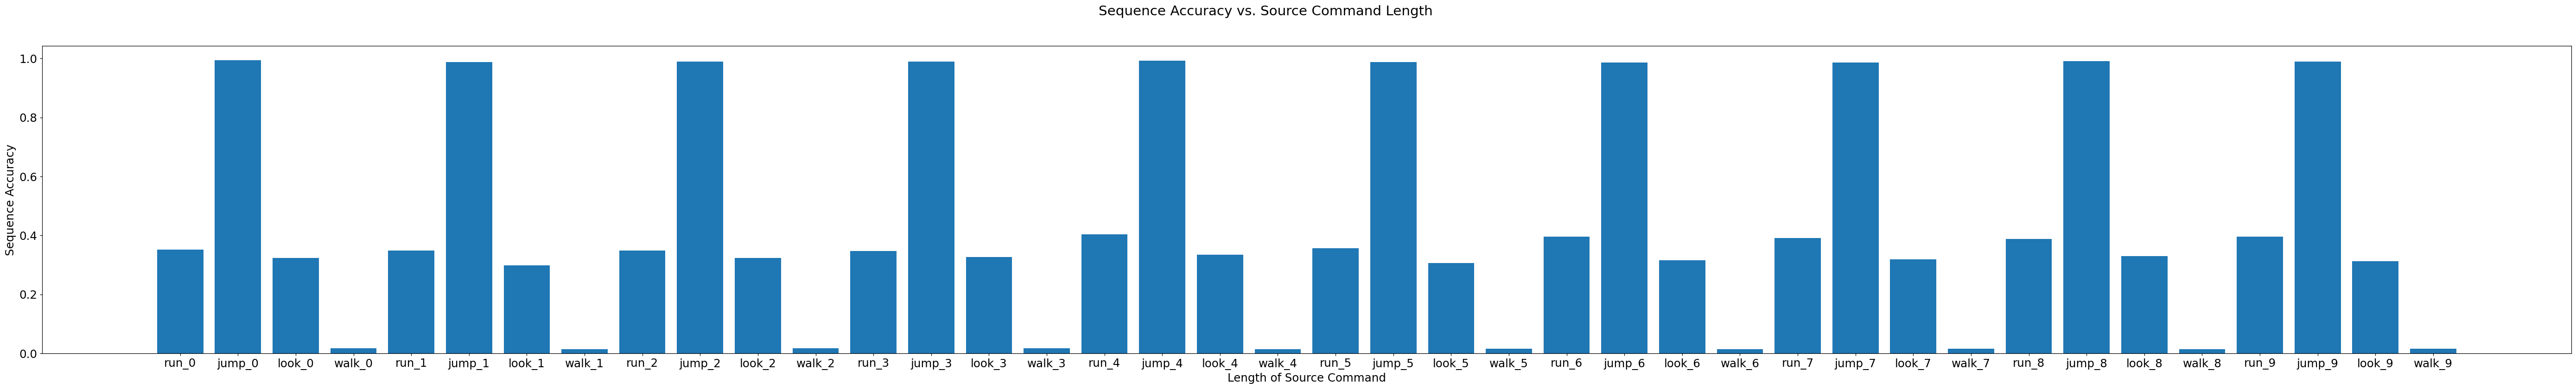

In [101]:
plt.subplots(figsize = (64, 8), dpi=110)
plt.bar(new_primitives, primitive_seq_acc_dict.values())
plt.xlabel('Length of Source Command')
plt.ylabel('Sequence Accuracy')
plt.suptitle('Sequence Accuracy vs. Source Command Length')
plt.show()

### Case Study - run

In [24]:
# for x, y, y_ in zip(xs, ys, ys_):
#     if 'run' in ''.join(x):
#         print(x)
#         print(y)
#         print(y_)

## Source Length

In [25]:
lens_list = []
for x, y, y_ in zip(xs, ys, ys_):
    if y == y_:
        lens_list.append(len(x.split()))

In [26]:
c = Counter()
c.update(lens_list)
true_dict = dict(c)

print(true_dict)

{8: 4966, 7: 3800, 4: 443, 6: 1930, 9: 3313, 5: 670, 2: 60, 3: 210}


In [27]:
c = Counter()
c.update([len(x.split()) for x in xs])
all_dict = dict(c)

print(all_dict)

{7: 10240, 6: 6400, 8: 10240, 9: 5120, 4: 960, 5: 2560, 2: 160, 3: 400}


In [28]:
acc_lens = [true_dict[k] / all_dict[k] for k in true_dict.keys()]
acc_lens

[0.4849609375,
 0.37109375,
 0.46145833333333336,
 0.3015625,
 0.6470703125,
 0.26171875,
 0.375,
 0.525]

In [29]:
for k, a in zip(true_dict.keys(), acc_lens):
    print(k, a)

8 0.4849609375
7 0.37109375
4 0.46145833333333336
6 0.3015625
9 0.6470703125
5 0.26171875
2 0.375
3 0.525


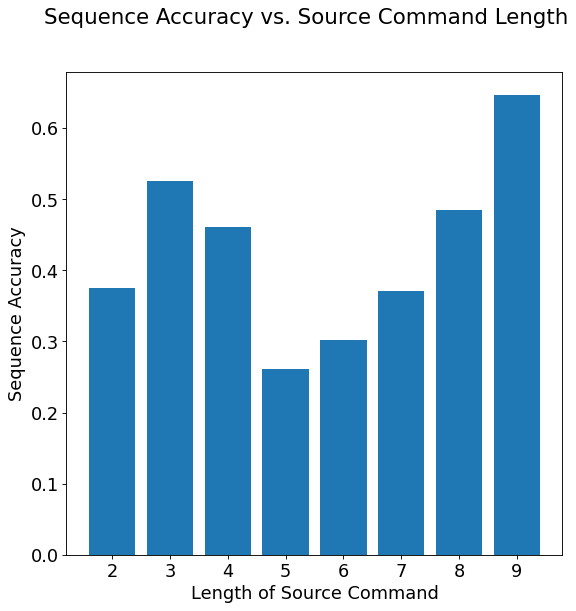

In [31]:
plt.subplots(figsize = (8, 8), dpi=80)
plt.bar(list(true_dict.keys()), acc_lens)
plt.xlabel('Length of Source Command')
plt.ylabel('Sequence Accuracy')
plt.suptitle('Sequence Accuracy vs. Source Command Length')
plt.show()